# USAspending API in Python

by Michael T. Moen

Please see the following resources for more information on API usage:

- Documentation
    - <a href="https://www.usaspending.gov/" target="_blank">USAspending Website</a>
    - <a href="https://api.usaspending.gov/" target="_blank">USAspending Documentation</a>
- Terms
    - <a href="https://github.com/fedspendingtransparency/usaspending-api?tab=CC0-1.0-1-ov-file" target="_blank">USAspending API License</a>: <a href="" target="_blank">CC0 1.0 Univeral</a>
- Data Reuse
    - <a href="https://www.usaspending.gov/about#about-licensing" target="_blank">USAspending Data Reuse</a>

*These recipe examples were tested on May 5, 2025.*

## Setup

The following external libraries need to be installed into your environment to run the code examples in this tutorial:

- <a href="https://github.com/ipython/ipykernel" target="_blank">ipykernel</a>
- <a href="https://github.com/psf/requests" target="_blank">requests</a>
- <a href="https://github.com/matplotlib/matplotlib" target="_blank">matplotlib</a>
- <a href="https://github.com/numpy/numpy" target="_blank">numpy</a>

We import the libraries used in this tutorial below:

In [1]:
import requests
import matplotlib.pyplot as plt
import numpy as np

## 1. Get Agency Names and Toptier Codes

To obtain data from the API, it is useful to first build a dictionary containing agency names and toptier codes, the latter of which will be used to access subagency data. The toptier codes serve as unique identifiers for each agency, so they are needed for accessing some of the data in the API.

In [11]:
BASE_URL = "https://api.usaspending.gov/api/v2/"
toptier_agencies_endpoint = "references/toptier_agencies/"

# Import data from URL as a JSON file
toptier_response = requests.get(BASE_URL + toptier_agencies_endpoint)

# Response code of 200 indicates success
toptier_response.status_code

200

In [ ]:
toptier_data = toptier_response.json()["results"]

# Print number of agencies
len(toptier_data)

109

In [8]:
# Display data of first agency
toptier_data[0]

{'agency_id': 1525,
 'toptier_code': '247',
 'abbreviation': 'AAHC',
 'agency_name': '400 Years of African-American History Commission',
 'congressional_justification_url': None,
 'active_fy': '2025',
 'active_fq': '2',
 'outlay_amount': 1773589.26,
 'obligated_amount': 7217.52,
 'budget_authority_amount': 2919754.67,
 'current_total_budget_authority_amount': 14651831778670.89,
 'percentage_of_total_budget_authority': 1.9927574340911925e-07,
 'agency_slug': '400-years-of-african-american-history-commission'}

Now we can create a dictionary containing the agency names as keys and the toptier codes as the data. 

In [9]:
# Compile dictionary containing agency names and toptier codes
toptier_codes = {record["agency_name"] : record["toptier_code"] for record in toptier_data}

# Display data
toptier_codes

{'400 Years of African-American History Commission': '247',
 'Access Board': '310',
 'Administrative Conference of the U.S.': '302',
 'Advisory Council on Historic Preservation': '306',
 'African Development Foundation': '166',
 'Agency for International Development': '072',
 'American Battle Monuments Commission': '074',
 'Appalachian Regional Commission': '309',
 'Armed Forces Retirement Home': '084',
 'Barry Goldwater Scholarship and Excellence In Education Foundation': '313',
 "Commission for the Preservation of America's Heritage Abroad": '321',
 'Commission of Fine Arts': '323',
 'Commission on Civil Rights': '326',
 'Committee for Purchase from People Who Are Blind or Severely Disabled': '338',
 'Commodity Futures Trading Commission': '339',
 'Consumer Financial Protection Bureau': '581',
 'Consumer Product Safety Commission': '061',
 'Corporation for National and Community Service': '485',
 'Corps of Engineers - Civil Works': '096',
 'Council of the Inspectors General on Integr

Finally, let's print the toptier code for a particular agency using the `toptier_codes` dictionary we built. This will be useful when building URLs to view other data from the API.

In [10]:
toptier_codes["Department of Transportation"]

'069'

With this information, we can access subagency data using the toptier codes.

## 2. Retrieving Data from Subagencies

The toptier_codes dictionary we created above contains every agency name in the API. For this example, we'll look at the total obligations of each subagency of the Department of Defense.

In [ ]:
# Set this to the desired department
agency_name = 'Department of Defense'

dod_url = f"{BASE_URL}agency/{toptier_codes[agency_name]}/sub_agency/"
params = {
    'fiscal_year': 2024
}

dod_response = requests.get(dod_url, params=params)

# Status code 200 indicates success
dod_response.status_code

200

In [ ]:
# Extract data from HTTP response
dod_data = dod_response.json()['results']

# Define dictionary with subagency names as keys and total_obligations as the data
dod_subagencies = {data['name']: data['total_obligations'] for data in dod_data}

dod_subagencies

{'Department of the Navy': 135174201255.6,
 'Department of the Army': 108068852362.25,
 'Department of the Air Force': 101546786153.31,
 'Defense Logistics Agency': 53055966604.09,
 'Defense Health Agency': 20211030486.08,
 'Missile Defense Agency': 8449104369.2,
 'Defense Information Systems Agency': 7104135597.93,
 'USTRANSCOM': 5249039584.72,
 'U.S. Special Operations Command': 4902029625.0,
 'Washington Headquarters Services': 3403051572.15}

We'll represent our data using a pie chart. To make the data easier to read, we can create an "Other" category for smaller subagencies.

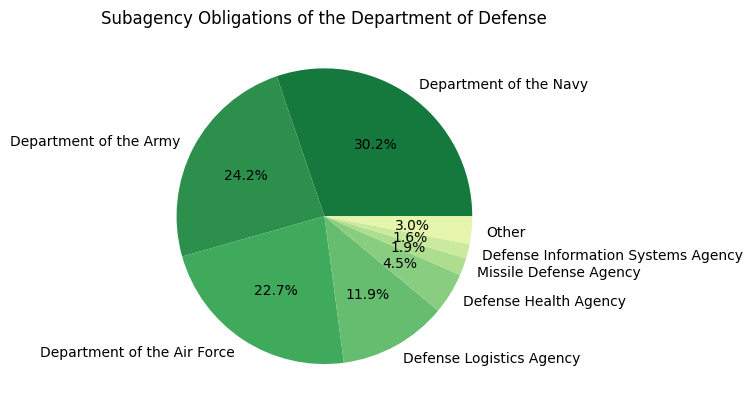

In [ ]:
subagency_names = list(dod_subagencies.keys())
subagency_obligations = list(dod_subagencies.values())

threshold = 0.015 # Sectors under this value are combined into an "Other" category in the chart
total_obligations = sum(dod_subagencies.values()) # the total obligations of the agency

# Count the number of slices below the threshold
small_slices = sum(1 for i in subagency_obligations if i < threshold * total_obligations)

# If multiple slices are under the threshold, combine the slices into an "Other" slice
if small_slices > 1:
    other_obligations = 0
    i = len(subagency_obligations) - 1
    while i >= 0:
        if subagency_obligations[i] < threshold * total_obligations:
            other_obligations += subagency_obligations[i]
            subagency_names.pop(i)
            subagency_obligations.pop(i)
        i -= 1
    subagency_obligations.append(other_obligations)
    subagency_names.append("Other")

# Configure color of pie chart
cmap = plt.get_cmap('YlGn_r')
colors = cmap(np.linspace(0.2, 0.8, len(subagency_obligations)))

fig, ax = plt.subplots()
plt.pie(subagency_obligations, labels=subagency_names, autopct='%1.1f%%', colors=colors)
plt.title(f"Subagency Obligations of the {agency_name}")

plt.show()

## 3. Accessing Fiscal Data Per Year

We can use the API to examine the annual budget of an agency from 2017 onward.

In [ ]:
agency_name = "Department of Health and Human Services"

hhs_url = f"{BASE_URL}agency/{toptier_codes[agency_name]}/budgetary_resources/"

hhs_response = requests.get(hhs_url)

# Status code 200 indicates sucess
hhs_response.status_code

200

In [ ]:
hhs_data = hhs_response.json()["agency_data_by_year"]

# Number of years contained in the data
len(hhs_data)

9

Now we can create a dictionary to store the budgets using the years as keys.

In [ ]:
# Create dictionary with fiscal_year as the key and agency_total_obligated as the data
budget_by_year = {item['fiscal_year'] : item['agency_total_obligated'] for item in hhs_data}

# Print results
budget_by_year

{2025: 1367556553152.74,
 2024: 2518647728970.53,
 2023: 2475673980552.7,
 2022: 2452969781323.39,
 2021: 2355524286884.46,
 2020: 2198882208891.79,
 2019: 1814270463757.37,
 2018: 1679128003253.74,
 2017: 1646989531123.68}

The budget data for the current year (2025 at the time of writing) does not contain the entire annual budget, so let's remove that entry from the data.

In [31]:
budget_by_year.pop(2025)

# Print updated dictionary
budget_by_year

{2024: 2518647728970.53,
 2023: 2475673980552.7,
 2022: 2452969781323.39,
 2021: 2355524286884.46,
 2020: 2198882208891.79,
 2019: 1814270463757.37,
 2018: 1679128003253.74,
 2017: 1646989531123.68}

Now we'll use matplotlib to create a bar graph for this information.

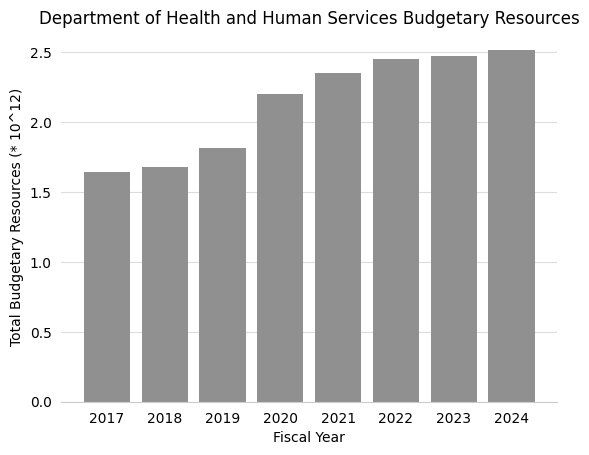

In [32]:
lists = sorted(budget_by_year.items())
years, budgets = zip(*lists)

# Create scale for bar graph
min = sorted(list(budgets), key=float)[0]
exponent = len(str(int(min)))-1

budgets = [x/(10**exponent) for x in budgets]

fig, ax = plt.subplots()

# Format the bar graph
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#CCCCCC')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#DDDDDD')
ax.xaxis.grid(False)

plt.bar(years, budgets, color='#909090')
plt.title(agency_name + " Budgetary Resources")
plt.xlabel("Fiscal Year")
plt.ylabel(f"Total Budgetary Resources (* 10^{exponent})")
plt.show()

## 4. Breaking Down Budget Categories

We can use the API to view the breakdown the spending of a particular agency.

In [33]:
agency_name = "Department of the Interior"

doi_url = f"{BASE_URL}agency/{toptier_codes[agency_name]}/obligations_by_award_category/"
params = {
    'fiscal_year': 2023
}

doi_response = requests.get(doi_url, params=params)

# Status code 200 indicates success
doi_response.status_code

200

In [ ]:
# Extract data from HTTP response
doi_data = doi_response.json()
aggregated_total = doi_data["total_aggregated_amount"]
obligations_data = doi_data["results"]

# Print results
obligations_data

[{'category': 'contracts', 'aggregated_amount': 7639774240.23},
 {'category': 'direct_payments', 'aggregated_amount': 3363870101.97},
 {'category': 'grants', 'aggregated_amount': 7146409904.93},
 {'category': 'idvs', 'aggregated_amount': 3579835.81},
 {'category': 'loans', 'aggregated_amount': 0.0},
 {'category': 'other', 'aggregated_amount': 338002603.98}]

Let's create a dictionary to store this data.

In [35]:
budget_breakdown = {}

# Add entry to budget_breakdown dictionary only if the amount is greater than zero
for record in obligations_data:
    if record["aggregated_amount"] > 0:
        budget_breakdown[record["category"]] = record["aggregated_amount"]

budget_breakdown

{'contracts': 7639774240.23,
 'direct_payments': 3363870101.97,
 'grants': 7146409904.93,
 'idvs': 3579835.81,
 'other': 338002603.98}

In order to graph the data, we have to reformat and filter out some of our data:

In [36]:
threshold = 0.02 # any sector under this threshold will be combined into an "other" category

# Count the number of small slices
small_slices = sum(1 for i in budget_breakdown.values() if threshold > i/aggregated_total)

if small_slices > 1:
    
    keys_to_remove = []
    
    for key, value in budget_breakdown.items():
        if key == 'other' or threshold < value/aggregated_total:
            continue
        if 'other' not in budget_breakdown.keys():
            budget_breakdown['other'] = 0
        budget_breakdown['other'] += value
        keys_to_remove.append(key)
    
    for key in keys_to_remove:
        budget_breakdown.pop(key)

budget_type = list(budget_breakdown.keys())
budget_amount = list(budget_breakdown.values())
budget_percentages = [x/aggregated_total for x in budget_amount]

Now, we can graph the data with a stacked bar chart:

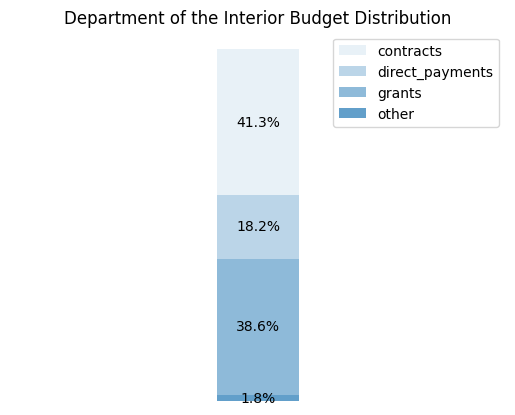

In [ ]:
fig, ax = plt.subplots()
bottom = 1

for j, (height, label) in enumerate([*zip(budget_percentages, budget_type)]):
    bottom -= height
    bc = ax.bar(0,
                height=height,
                label=label,
                width=2,
                bottom=bottom,
                alpha=0.1 + 0.2 * j,
                align='center',
                color='C0')
    ax.bar_label(bc, labels=[f"{height:.1%}"], label_type='center')

ax.set_title(f'{agency_name} Budget Distribution')
ax.legend()
ax.axis('off')
ax.set_xlim(-6, 6)

plt.show()

We can also plot this data as a pie chart.

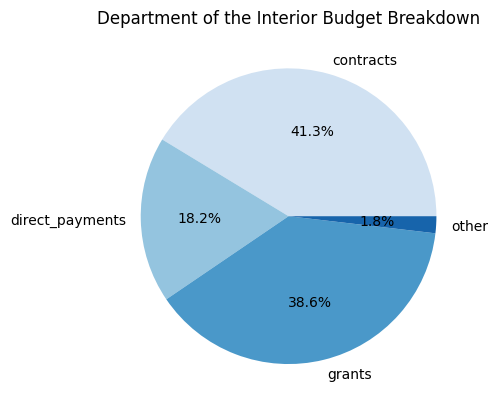

In [39]:
lists = sorted(budget_breakdown.items())
types, budgets = zip(*lists)

fig, ax = plt.subplots()

# Configure color of pie chart
cmap = plt.get_cmap('Blues')
colors = cmap(np.linspace(0.2, 0.8, len(budgets)))

plt.pie(budgets, labels=types, autopct='%1.1f%%', colors=colors)
plt.title(f"{agency_name} Budget Breakdown")
plt.show()